In [1]:
import datastore

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

otherData = datastore.getOtherNordPoolData()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()


Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 76
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 876
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1353
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 155
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 349
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 392
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 360
Missing v

In [2]:
import numpy as np

dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen], axis=1)

dataset.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [52]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, RecurrentNetwork

import calendar_features as cf

dataset = cf.calendar_transformer(dataset)

time_index = np.arange(0, len(dataset))

dataset["time_index"] = time_index
dataset["group_ids"] = "SE3" # add dummy variable for group_ids, only one called "SE3"

max_prediction_length = 24  
max_encoder_length = 24 * 2 

training_cutoff = int(len(dataset)*0.6)

time_varying_known_categoricals = ["year", "month", "day_of_week", "weekend", "hour"]

for col in time_varying_known_categoricals:
    dataset[col] =  dataset[col].astype(str)

time_varying_unknown_reals = spot.columns.tolist() + cons_gwh.columns.tolist() + \
    production_se1_mwh.columns.tolist() + production_se2_mwh.columns.tolist() + \
    production_se3_mwh.columns.tolist() + production_se4_mwh.columns.tolist() + \
    ["Temperature(day)"]

time_varying_known_reals = ["PrecipitationEnergySE(day)", 
                            "PrecipitationEnergyNO(day)",
                            "PrecipitationEnergyFI(day)"]

In [49]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder


training = TimeSeriesDataSet(
    dataset[lambda x: x.time_index <= training_cutoff],
    
    time_idx = "time_index",
    target="spotPrice",
    group_ids= ["group_ids"],
    
    min_encoder_length = max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    
    time_varying_known_categoricals = time_varying_known_categoricals,
    categorical_encoders= {'year': NaNLabelEncoder(add_nan=True), 'month': NaNLabelEncoder(add_nan=True), 
                           'day_of_week': NaNLabelEncoder(add_nan=True), 'weekend': NaNLabelEncoder(add_nan=True), 
                           'hour': NaNLabelEncoder(add_nan=True)},
    
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, dataset, predict=True, stop_randomization=True)

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 3 unknown classes which were set to NaN
  warnings.warn(


In [50]:
from pytorch_forecasting import Baseline, MAE

batch_size = 256
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=35,
    enable_model_summary=True,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1
)

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
from pytorch_forecasting.metrics import QuantileLoss, RMSE

rnn = RecurrentNetwork.from_dataset(
    training, 
    learning_rate = 0.03,
    hidden_size = 16,
    rnn_layers = 2,
    dropout = 0.1,
    loss = RMSE(),
    log_interval = 10,
    reduce_on_plateau_patience = 4
)
    
    

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


AssertionError: Encoder and decoder variables have to be the same apart from target variable

In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [19]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 345   
3  | prescalers                         | ModuleDict                      | 560   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [21]:
import torch
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(tft.device)

predictions = tft.predict(val_dataloader).to(tft.device)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


200.9148406982422
tensor([200.9148])


In [ ]:
tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


IndexError: index 1 is out of bounds for dimension 0 with size 1

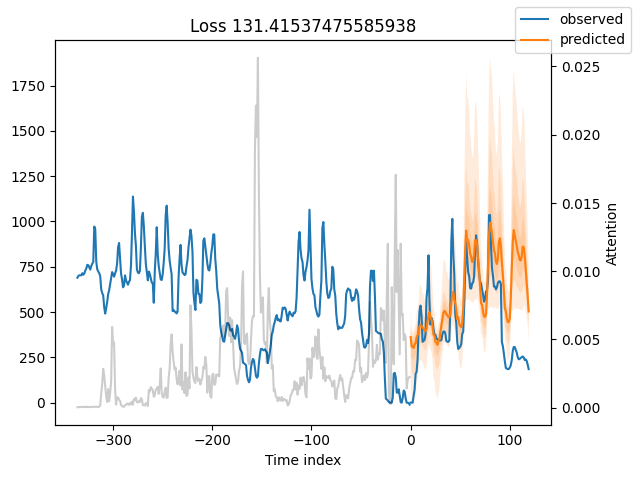

In [23]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    